In [1]:
!pip install neurodiffeq

In [2]:
# Import necessary libraries
import torch
import numpy as np
from tqdm.notebook import tqdm
from scipy.integrate import odeint

import neurodiffeq
from neurodiffeq import diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, NoCondition, BundleDirichletBVP
from neurodiffeq.solvers import *
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D, PredefinedGenerator, BaseGenerator, PredefinedGenerator
from neurodiffeq.callbacks import ActionCallback
from neurodiffeq import diff

import copy as copy
import cmath as cmath
import types

In [3]:
# Helper code to make graphs look better
import seaborn as sns
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
large = 24; medium = 18; small = 12
colors = ['#66bb6a', '#558ed5', '#dd6a63', '#dcd0ff', '#ffa726', '#8c5eff', '#f44336', '#00bcd4', '#ffc107', '#9c27b0']
params = {'axes.titlesize': medium,
          'legend.fontsize': small,
          'figure.figsize': (8, 8),
          'axes.labelsize': small,
          'axes.linewidth': 2,
          'xtick.labelsize': small,
          'xtick.color' : '#1D1717',
          'ytick.color' : '#1D1717',
          'ytick.labelsize': small,
          'axes.edgecolor':'#1D1717',
          'figure.titlesize': medium,
          'axes.prop_cycle': cycler(color = colors),}
plt.rcParams.update(params)
%matplotlib inline

vec_sqrt = np.vectorize(cmath.sqrt)
vec_exp = np.vectorize(cmath.exp)
vec_cosh =  np.vectorize(cmath.cosh)
vec_sinh =  np.vectorize(cmath.sinh)

def _requires_closure(optimizer):
    # starting from torch v1.13, simple optimizers no longer have a `closure` argument
    closure_param = inspect.signature(optimizer.step).parameters.get('closure')
    return closure_param and closure_param.default == inspect._empty

# Mesh generators for the bundle solver #
class MeshGenerator(BaseGenerator):

    def __init__(self, g1, pg):

        super(MeshGenerator, self).__init__()
        self.g1 = g1
        self.pg = pg

    def get_examples(self):

        u = self.g1.get_examples()
        u = u.reshape(-1, 1, 1)

        bundle_params = self.pg.get_examples()
        if isinstance(bundle_params, torch.Tensor):
            bundle_params = (bundle_params,)
        assert len(bundle_params[0].shape) == 1, "shape error, ask shuheng"
        n_params = len(bundle_params)

        bundle_params = torch.stack(bundle_params, dim=1)
        bundle_params = bundle_params.reshape(1, -1, n_params)

        uu, bb = torch.broadcast_tensors(u, bundle_params)
        uu = uu[:, :, 0].reshape(-1)
        bb = [bb[:, :, i].reshape(-1) for i in range(n_params)]

        return uu, *bb

class DoSchedulerStep(ActionCallback):
    def __init__(self, scheduler):
        super().__init__()
        self.scheduler = scheduler

    def __call__(self, solver):
        self.scheduler.step()

In [4]:
# CREATE THE CLASS OF THE EQUATIONS #
class NET(nn.Module):
    def __init__(self, H_model, head_model):
        super(NET, self).__init__()
        self.H_model = H_model
        self.head_model = head_model

    def forward(self, x):
        x = self.H_model(x)
        x = self.head_model(x)
        return x

# MULTIHEAD NN FREEZE #
class NET_FREEZE(nn.Module):
    def __init__(self, H_model, head_model):
        super(NET_FREEZE, self).__init__()

        for param in H_model.parameters():
            param.requires_grad = False
        self.H_model = H_model
        self.head_model = head_model
        # Freeze the parameters of H_model
        #for param in self.H_model.parameters():
            #param.requires_grad = False

    def forward(self, x):
        x = self.H_model(x)
        x = self.head_model(x)
        return x


In [5]:
# DEFINE THE EQUATIONS #
def generate_equations(n_heads):
  eq_dict = {} # Initialize the dictionary
  # Loop to create functions
  for head in range(n_heads):
      # Define a new function using a lambda or nested function
      def make_equations(head):
        def eq(x,y,t):
          a = a_list[head]
          eq1 = diff(y,t) - rho*a*(1-x**2)*y + x*rho
          eq2 = diff(x,t)-y*rho
          return [eq1, eq2]
        return eq
      # Store the function in the dictionary
      eq_dict.update({f'equations_{head}':make_equations(head)})  # Now at the correct indentation level
  print('Equations dictionary generated')
  print(eq_dict)
  return eq_dict


def van_der_pol(t, state, mu):
    x, y = state
    dxdt = rho*y
    dydt = rho*mu * (1 - x**2) * y - x*rho
    return np.array([dxdt, dydt])

# Runge-Kutta 4th order method
def rk4_step(func, t, state, dt, mu):
    k1 = func(t, state, mu)
    k2 = func(t + dt/2, state + dt*k1/2, mu)
    k3 = func(t + dt/2, state + dt*k2/2, mu)
    k4 = func(t + dt, state + dt*k3, mu)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

In [6]:
# Custom solver to implement the MH with a variable parameter a #
class Solver1D_MH(BundleSolver1D):
  def __init__(self, a_list, all_nets, t_sampling, flatten=False, *args, **kwargs):

        self.n_heads = len(a_list)
        self.a_list = a_list
        ################################
        self.dV = None
        self.TL = flatten
        self.equations = kwargs.pop('ode_system')
        #self.equations = ode_set

       # self.ode_set=[]
        #for head in range(self.n_heads):
         #   self.ode_set.append(self.equations[head])

        #self.V = kwargs.pop('V', None)
        self.alpha_2 = 0  #int(input('Loss coeff: '))

        t_gen = Generator1D(t_sampling,t_min,t_max,'equally-spaced-noisy')
        self.ode_list = []
        self.all_generators = []
        for head in range(self.n_heads):
            a_elem = torch.tensor(a_list[head])
            pg = PredefinedGenerator([a_elem])
            print('head',head)
            #ode_system = kwargs.pop('ode_system')
            ode_system = self.equations[head]
            print('Inside solver __init()__:', ode_system)
            super().__init__(ode_system=ode_system, *args, **kwargs)
            self.ode_list.append(self.diff_eqs)
            # Prepare all the generators #
            self.all_generators.append(MeshGenerator(t_gen,pg))
            #print('self.diff_eqs after super().__init__()', self.diff_eqs)

        #print('ode_list', self.ode_list, self.ode_list[0])
        self.all_nets = all_nets
        self.head_add_loss = []
        self.metrics_history['r2_loss'] = []
        #self.metrics_history['head_add_loss'] = []
        self.metrics_history['add_loss'] = []
        self.metrics_history['DE_loss'] = []
       # self.metrics_fn = {"add_loss": 0.0,
        #                   "DE_loss": 0.0
        #}

        #print('ode_list', self.ode_list, self.ode_list[0])
        self.all_nets = all_nets
        self.best_nets_list = np.ones(self.n_heads,dtype = object)
        self.metrics_history['r2_loss'] = []
        self.metrics_history['add_loss'] = []
        self.metrics_history['phi_max'] = []
  def custom_epoch(self, key):
        r"""Run an epoch on train/valid points, update history, and perform an optimization step if key=='train'.

        :param key: {'train', 'valid'}; phase of the epoch
        :type key: str

        .. note::
            The optimization step is only performed after all batches are run.
        """
        if self.n_batches[key] <= 0:
            # XXX maybe we should append NaN to metric history?
            return
        self._phase = key

        tot_epoch_loss = 0.0
       # tot_epoch_add_loss = 0.0
       # tot_epoch_DE_loss = 0.0

        #batch_loss = 0.0


        loss = torch.tensor([0.0]) #, requires_grad=True) #added by me for multihead
        #add_loss = torch.tensor([0.0])
        #DE_loss = torch.tensor([0.0])


        metric_values = {name: 0.0 for name in self.metrics_fn}

        # Zero the gradient only once, before running the batches. Gradients of different batches are accumulated.
        if key == 'train' and not _requires_closure(self.optimizer):
            self.optimizer.zero_grad()

        # perform forward pass for all batches: a single graph is created and release in every iteration
        # see https://discuss.pytorch.org/t/why-do-we-need-to-set-the-gradients-manually-to-zero-in-pytorch/4903/17

        for head in range(self.n_heads):
            #print('head', head)
            head_epoch_loss = 0.0
           # head_epoch_add_loss = 0.0
           # head_epoch_DE_loss = 0.0

            self.nets = self.all_nets[:,head]
            self.diff_eqs = self.ode_list[head]

            self.generator[key] = self.all_generators[head]
            self.generator['valid'] = self.all_generators[head]
           # y = self.generator[key].get_examples()[1].detach().numpy()
           # plt.hist(y)
            #print(len(self.generator['train'].get_examples()))

            for batch_id in range(self.n_batches[key]):
                batch = self._generate_batch(key)

                #print(len(batch[0]))
               # print(self.n_batches[key])

                batch_loss = 0.0
               # batch_add_loss = 0.0
                #batch_DE_loss = 0.0

                def closure(zero_grad=True):
                    nonlocal batch_loss

                    if key == 'train' and zero_grad:
                        self.optimizer.zero_grad()
                    funcs = [
                        self.compute_func_val(n, c, *batch) for n, c in zip(self.nets, self.conditions)
                    ]

                    for name in self.metrics_fn:
                        value = self.metrics_fn[name](*funcs, *batch).item()
                        metric_values[name] += value

                    #CALLING THE EQUATIONS

                    residuals = self.diff_eqs(*funcs, *batch)
                    residuals = torch.cat(residuals, dim=1)
                   # print(residuals)

                    try:
                        DE_loss = self.loss_fn(residuals, funcs, batch)
                        add_loss = self.additional_loss(residuals, funcs, batch, head)
                        loss = DE_loss + add_loss

                        #self.metrics_history['add_loss'].append()

                        #print('Head' + str(head) + ' loss ' + str(loss))
                        #if self.global_epoch %100:
                            #print('loss ',head,'=',loss)

                    except TypeError as e:
                        warnings.warn(
                            "You might need to update your code. "
                            "Since v0.4.0; both `criterion` and `additional_loss` requires three inputs: "
                            "`residual`, `funcs`, and `coords`. See documentation for more.", FutureWarning)
                        raise e

                    # accumulate gradients before the current graph is collected as garbage

                    #DOING BACKPROPAGATION
                    if key == 'train':
                        loss.backward()
                        batch_loss = loss.item()
                      #  batch_add_loss = add_loss.item()
                       # batch_DE_loss = DE_loss.item()
                        #print('0',batch_loss)

                   # print(loss,add_loss,DE_loss)

                    return loss  #, add_loss, DE_loss

                if key == 'train':

                        # Optimizer step will be performed only once outside the for-loop (i.e. after all batches).
                    closure(zero_grad=False)    #closure(zero_grad=False) was inside else in initial code

                    #print('key 2.batch')

                    head_epoch_loss += batch_loss
                   # head_epoch_add_loss += batch_add_loss
                   # head_epoch_DE_loss += batch_DE_loss
                    #print('head_loss', head_epoch_loss)
                    #head_epoch_loss += closure().item()

            if key == 'train':
                if _requires_closure(self.optimizer):
                    self._do_optimizer_step(closure=closure)
                    #print('optimizer step, key 1 head')

                ##else:
                    #closure(zero_grad=False)
                    #print('key 2.head')

                tot_epoch_loss += head_epoch_loss
           #     tot_epoch_add_loss += head_epoch_add_loss
            #    tot_epoch_DE_loss += head_epoch_DE_loss
             #   print('epoch losses: ', tot_epoch_loss,tot_epoch_add_loss,tot_epoch_DE_loss)

            else:
                tot_epoch_loss += closure()[0].item()
              #  tot_epoch_add_loss += closure()[1].item()
               # tot_epoch_DE_loss += closure()[2].item()
                #print('key 3.head')

            # If validation is performed, update the best network with the validation loss
            # Otherwise, try to update the best network with the training loss
        #print(tot_epoch_loss)
        self.metrics_history['r2_loss'].append(tot_epoch_loss)


        if key == 'valid' or self.n_batches['valid'] == 0:
            self._update_best(key)

        # perform the optimizer step after all heads are run (if optimizer.step doesn't require `closure`)
        if key == 'train' and not _requires_closure(self.optimizer):
            self._do_optimizer_step()
            #print('optimizer step , key 4 head')

            #tot_epoch_loss += (head_epoch_loss / self.n_batches[key])

        # calculate the sum of all losses (one per head) and register to history

        self._update_history(tot_epoch_loss, 'loss', key)

     #   self.metrics_history['add_loss'].append(tot_epoch_add_loss)
      #  self.metrics_history['DE_loss'].append(tot_epoch_DE_loss)

        # calculate total metrics across heads (and averaged across batches) and register to history
        for name in self.metrics_fn:
            print(name)
            self._update_history(
                metric_values[name], name, key)


  def run_custom_epoch(self):
      r"""Run a training epoch, update history, and perform gradient descent."""
      self.custom_epoch('train')
  def _update_best(self, key):
        """Update ``self.lowest_loss`` and ``self.best_nets``
        if current training/validation loss is lower than ``self.lowest_loss``
        """
        current_loss = self.metrics_history['r2_loss'][-1]
        if (self.lowest_loss is None) or current_loss < self.lowest_loss:
            self.lowest_loss = current_loss
            for i in range(self.n_heads):
                self.best_nets_list[i] = deepcopy(self.all_nets[:,i])

  def fit(self, max_epochs, callbacks=(), tqdm_file='default', **kwargs):
      r"""Run multiple epochs of training and validation, update best loss at the end of each epoch.

      If ``callbacks`` is passed, callbacks are run, one at a time,
      after training, validating and updating best model.

      :param max_epochs: Number of epochs to run.
      :type max_epochs: int
      :param callbacks:
          A list of callback functions.
          Each function should accept the ``solver`` instance itself as its **only** argument.
      :rtype callbacks: list[callable]
      :param tqdm_file:
          File to write tqdm progress bar. If set to None, tqdm is not used at all.
          Defaults to ``sys.stderr``.
      :type tqdm_file: io.StringIO or _io.TextIOWrapper

      .. note::
          1. This method does not return solution, which is done in the ``.get_solution()`` method.
          2. A callback ``cb(solver)`` can set ``solver._stop_training`` to True to perform early stopping.
      """
      self._stop_training = False
      self._max_local_epoch = max_epochs

      self.callbacks = callbacks

      monitor = kwargs.pop('monitor', None)
      if monitor:
          warnings.warn("Passing `monitor` is deprecated, "
                        "use a MonitorCallback and pass a list of callbacks instead")
          callbacks = [monitor.to_callback()] + list(callbacks)
      if kwargs:
          raise ValueError(f'Unknown keyword argument(s): {list(kwargs.keys())}')  # pragma: no cover

      flag=False
      if str(tqdm_file) == 'default':
          bar = tqdm(
              total = max_epochs,
              desc='Training Progress',
              colour='blue',
              dynamic_ncols=True,
          )
      elif tqdm_file is not None:
          bar = tqdm_file
      else:
          flag=True



      for local_epoch in range(max_epochs):
            #stop training if self._stop_training is set to True by a callback
          if self._stop_training:
              break

          # register local epoch (starting from 1 instead of 0) so it can be accessed by callbacks
          self.local_epoch = local_epoch + 1
          #self.run_train_epoch()
          self.run_custom_epoch()
          self.run_valid_epoch()
          for cb in callbacks:
              cb(self)
          if not flag:
              bar.update(1)

  def additional_loss(self,r,f,x, head):
        g_det = 0.0
        der_g_det = 0.0
        flat_metric = 1.0 * len(self.nets)
        t = torch.linspace(t_min,t_max,100,requires_grad=True)
        a = torch.linspace(a_min,a_max,80,requires_grad=True)
        T,A = torch.meshgrid(t,a,indexing = 'ij')
        g_MAT = torch.ones_like(T)
        g_det = torch.ones_like(T)
        if head == self.n_heads-1 and self.global_epoch%100 == 0 and self.TL:
            for f in range(2):
              x = torch.cat([T.reshape(-1,1),A.reshape(-1,1)],dim = 1)  # t and a #
              H = self.nets[f].H_model(x)
              Omega = torch.cat([x,H],dim = 1)

              #gmunu = torch.zeros([len(x),len(x)])
              partial_omega = []
              for j in range(Omega.shape[1]):
                partial_omega.append(diff(Omega[:,j],x,shape_check = False))
              partial_omega = torch.stack(partial_omega)   # [Coordinate index, sampling , metric dimension] #
              partial_omega = torch.transpose(partial_omega,dim0 = 0,dim1 = 1) # [sampling ,coordinate index, metric dimension] #

              T,A = torch.meshgrid(t,a,indexing = 'ij')
              g_MAT = torch.matmul(torch.transpose(partial_omega,dim0 = 1,dim1 = 2),partial_omega )
              g_det += torch.sqrt(torch.linalg.det(g_MAT)).reshape_as(T)
            #der_g_det = diff(g_det,x,shape_check = False)
            self.dV = torch.sum(g_det-flat_metric)#+torch.sum(der_g_det**2)   # Indent this line to match the previous one
            #print(self.dV)
            plain_metric =  self.dV*4e-5  # Indent this line to match the previous one
            #print(plain_metric)
        else:
          plain_metric = torch.tensor([0.0])

        self.head_add_loss.append(plain_metric)


        if head == self.n_heads-1:
            add_loss_epoch = sum(self.head_add_loss)
            self.head_add_loss = []
            if torch.cuda.is_available():
                self.metrics_history['add_loss'].append(plain_metric.cpu().detach().numpy())
            else:
                self.metrics_history['add_loss'].append(plain_metric.detach().numpy())
        #print(plain_metric)
        return plain_metric

In [7]:
def save_nets(path,nets,optim,solver):
  H_state = []
  head_state = []
  for i in range(len(nets[:,0])):
    H_state.append(solver.best_nets_list[0][i].H_model.state_dict())
    for j in range(n_heads):
      head_state.append(solver.best_nets_list[j][i].head_model.state_dict())
  optim_state = optim.state_dict()
  global_epoch = solver.global_epoch
  loss = solver.metrics_history['train_loss']
  torch.save({'H_state':H_state,'head_state':head_state,'optim_state':optim_state,'global_epoch':global_epoch,
              'loss':loss, 'add_loss': solver.metrics_history['add_loss']} ,path)
def load_nets(path,nets,optim,solver):
  j = 0
  master_dict = torch.load(path,map_location=torch.device('cpu'))
  H_state = master_dict['H_state']
  head_state = master_dict['head_state']
  optim_state = master_dict['optim_state']
  loss = master_dict['loss']
  global_epoch = master_dict['global_epoch']
  #solver.global_epoch = global_epoch
  lh = input('Load head? ')
  solver.metrics_history['train_loss'] = loss
  for i in range(len(nets[:,0])):
    nets[i,0].H_model.load_state_dict(H_state[i])
    if lh=='True':
        print('Loading heads...')
        nets[i,0].head_model.load_state_dict(head_state[4+j])
        j += 4
    #for j in range(n_heads):
     # nets[i,j].head_model.load_state_dict(head_state[i])
  #optim.load_state_dict(optim_state)

In [8]:
# Define the function to get the exact solution
def f(t,a):
    # Calculate the expression components
    sqrt_term = vec_sqrt(-4 + a**2)
    exp_term = vec_exp(-((a * t) / 2))
    cosh_term = vec_cosh(1/2 * sqrt_term * t)
    sinh_term = vec_sinh(1/2 * sqrt_term * t)

    # Combine the components to get the final expression
    result = exp_term * (cosh_term + (a * sinh_term) / sqrt_term)

    return result

In [8]:
# Initialize t_min, t_max, a_min and a_max

rho = 10

t_min = 0.0
t_max = 1

a_min = 0.0
a_max = 1.5

a_list = np.linspace(a_min,a_max,5)
n_heads = int(len(a_list))

# Create the body and the nets #
H = [FCNN(n_input_units=2, hidden_units=[64,64,64,64], n_output_units = 128) for _ in range(2)]

heads = [[FCNN(n_input_units=128, hidden_units=[64,64], n_output_units = 1) for _ in range(n_heads)]for _ in range(len(H))]

nets = np.ones([len(H),n_heads],dtype=nn.Module) # i -> equation, j -> head #
for i in range(len(H)):
    #print(i)
    for j in range(n_heads):
        nets[i,j] = NET(H[i],heads[i][j])

# Create the equations #
eq_dict = {}
eq_dict = generate_equations(n_heads = n_heads)
#print(self.eq_dict)
equation_list = []
for head in range(n_heads):
    equations = eq_dict[f'equations_{head}']
    #print(equations)
    equation_list.append(equations)

print('Equation list ready')

print(nets.shape)

#gen = Generator1D(48,t_min,t_max,'equally-spaced-noisy')

adam = torch.optim.Adam(OrderedSet([ p for q in range(n_heads) for net in list(nets[:,q])
                                    for p in net.parameters()]), lr=1e-3,amsgrad=True)

scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=15000, gamma=0.975)
scheduler_cb = DoSchedulerStep(scheduler=scheduler)


Equations dictionary generated
{'equations_0': <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2b030d440>, 'equations_1': <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2b030d580>, 'equations_2': <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2b030d120>, 'equations_3': <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2b030cd60>, 'equations_4': <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2b030cfe0>}
Equation list ready
(2, 5)


In [10]:
# Define the initial conditions

init_val = [BundleIVP(t_min,1),
            BundleIVP(t_min,0)]

# Initialize the solver
solver = Solver1D_MH(a_list = a_list,
    all_nets = nets,
    t_sampling = 64,
    optimizer = adam,
    ode_system =  equation_list,
    conditions = init_val,
    t_min = t_min,
    t_max = t_max,
    flatten = True,
    n_batches_valid = 0
   #train_generator=gen,
)

head 0
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2f1167a60>
head 1
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.eq at 0x10a3307c0>
head 2
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2f1167ba0>
head 3
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2f11671a0>
head 4
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.eq at 0x2f11679c0>


In [11]:
solver.nets

[FCNN(
   (NN): Sequential(
     (0): Linear(in_features=1, out_features=32, bias=True)
     (1): Tanh()
     (2): Linear(in_features=32, out_features=32, bias=True)
     (3): Tanh()
     (4): Linear(in_features=32, out_features=1, bias=True)
   )
 ),
 FCNN(
   (NN): Sequential(
     (0): Linear(in_features=1, out_features=32, bias=True)
     (1): Tanh()
     (2): Linear(in_features=32, out_features=32, bias=True)
     (3): Tanh()
     (4): Linear(in_features=32, out_features=1, bias=True)
   )
 )]

In [24]:
#torch.autograd.set_detect_anomaly(True)
# Fit the solver
solver.fit(1500000,
               callbacks = [scheduler_cb])

Training Progress:   0%|                            | 0/1500000 [00:00<?, ?it/s]

In [25]:
for g in adam.param_groups:
  print(g['lr'])
  #g['lr'] = 6e-5
    

6.322999386970518e-06


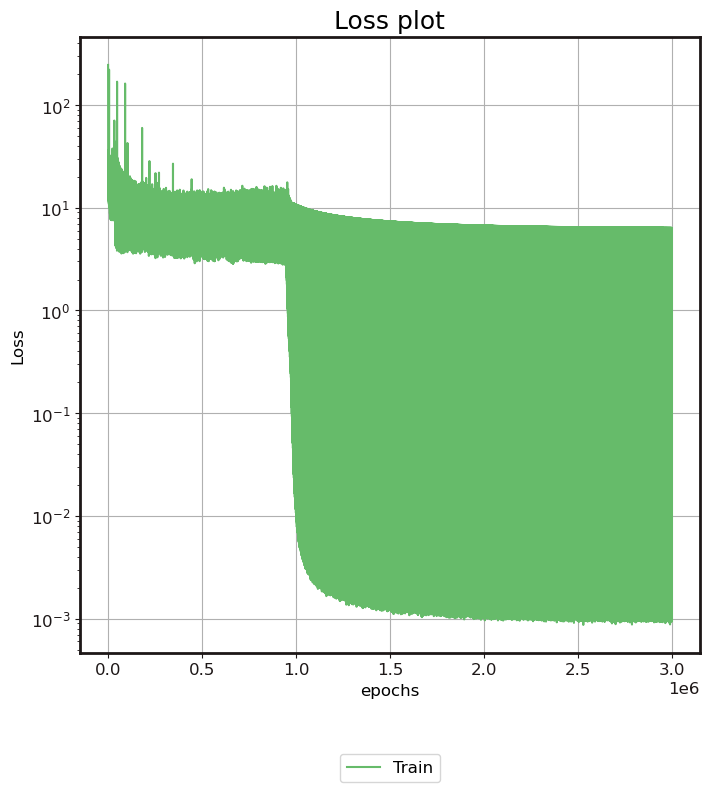

In [26]:
## Plot training history
history = solver.metrics_history
plt.plot(history['train_loss'], label = 'Train')
#print(history['add_loss'])
#plt.plot(history['add_loss'], label = 'Add')


#
#if len(history['valid_loss']) != 0:
#    plt.plot(history['valid_loss'], label = 'Validation')

# Add axis labels, title and legend for clarity
plt.title('Loss plot')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
plt.savefig('loss_body_flat.pdf')
plt.show()

In [27]:
t_vals = np.linspace(t_min, t_max, 100)
#a_vals = np.linspace(0,2,100)

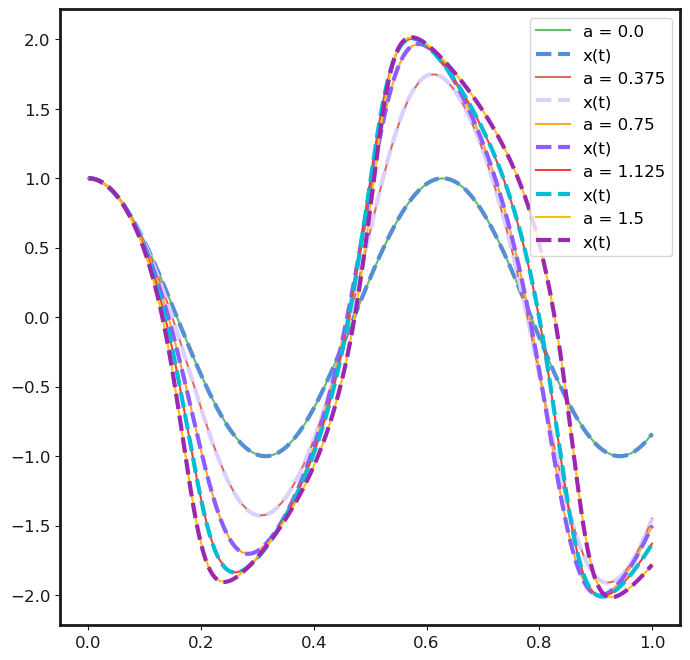

In [28]:
# Plot the variations of solutions for 5 values between a_min and a_max.
# Define the Van der Pol oscillator equations

# Parameters
#mu = 2.0  # Damping parameter
t0 = 0.0  # Initial time
t_end = 1  # End time
dt = 0.0001  # Time step
n_steps = int((t_end - t0) / dt)  # Number of time steps

# Initial conditions
x0 = 1.0
y0 = 0.0
state = np.array([x0, y0])

# Time array
t = np.linspace(t0, t_end, n_steps)

# Arrays to store the solutions
x_sol = np.zeros(n_steps)
y_sol = np.zeros(n_steps)
x_sol[0] = x0
y_sol[0] = y0

# Time integration using RK4


for head in range(solver.n_heads):
    solver.best_nets = nets[:,head]
    solution = solver.get_solution(best=True)
    a = a_list[head]*np.ones_like(t_vals)
    y1 = solution(t_vals,a)[0]
    plt.plot(t_vals,y1.detach().numpy(),label = 'a = ' + str(a_list[head]))
    # Numerical solver #
    # Initial conditions
    x0 = 1.0
    y0 = 0.0
    state = np.array([x0, y0])

    # Time array
    t = np.linspace(t0, t_end, n_steps)

    # Arrays to store the solutions
    x_sol = np.zeros(n_steps)
    y_sol = np.zeros(n_steps)
    x_sol[0] = x0
    y_sol[0] = y0
    for i in range(1, n_steps):
        state = rk4_step(van_der_pol, t[i-1], state, dt, a[0])
        x_sol[i] = state[0]
        y_sol[i] = state[1]
    plt.plot(t, x_sol, label='x(t)',linestyle = 'dashed', linewidth = 3)
plt.legend()
plt.savefig('MH_solutions_flat.pdf')
plt.show()

In [29]:
# Try to compute the 2x2 metric of this problem #

The idea that we got was the following. Imagine that we are training on a set of $t \in (0,1)$, and a set of the bundle parameter $ a \in (0,2)$. It is important that we are training a multihead, which ouput of the body can be expressed as $\vec{H}(t,a)$. Then, we can construct a geometry given by the following coordinates:
$$\hat{\Omega} = (t,a,\vec{H}(t,a))$$
The metric can be computed as follows
$$g_{\mu\nu} \,=\, \partial_\mu \hat{\Omega} \cdot\partial_\nu \hat{\Omega}$$

In [30]:
import time
import copy
from neurodiffeq import diff

start = time.time()

t = torch.linspace(t_min,t_max,80,requires_grad=True)
a = torch.linspace(a_min,a_max,70,requires_grad=True)
T,A = torch.meshgrid(t,a,indexing = 'ij')
g_MAT = torch.ones_like(T)
g_det = torch.ones_like(T)

x = torch.cat([T.reshape(-1,1),A.reshape(-1,1)],dim = 1)  # t and a #
H = solver.best_nets[0].H_model(x)
print(H.shape,x.shape)
Omega = torch.cat([x,H],dim = 1)

#gmunu = torch.zeros([len(x),len(x)])
partial_omega = []
for j in range(Omega.shape[1]):
  partial_omega.append(diff(Omega[:,j],x,shape_check = False))
partial_omega = torch.stack(partial_omega)   # [Coordinate index, sampling , metric dimension] #
partial_omega = torch.transpose(partial_omega,dim0 = 0,dim1 = 1) # [sampling ,coordinate index, metric dimension] #

T,A = torch.meshgrid(t,a,indexing = 'ij')
g_MAT = torch.matmul(torch.transpose(partial_omega,dim0 = 1,dim1 = 2),partial_omega )
g_det = torch.sqrt(torch.linalg.det(g_MAT)).reshape_as(T)
end = time.time()
print(end - start)

torch.Size([5600, 128]) torch.Size([5600, 2])
0.681164026260376


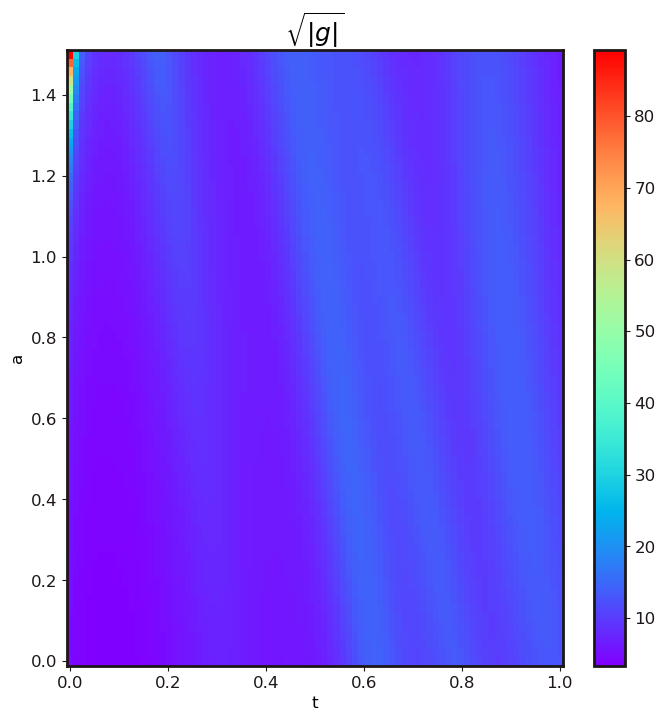

In [31]:
import matplotlib.colors as colors
pos = 0
plt.pcolormesh(T.detach().numpy()[pos:,::],A.detach().numpy()[pos:,::],g_det.detach().numpy()[pos:,::],cmap = 'rainbow')
plt.colorbar()
plt.title('$\sqrt{|g|}$')
plt.xlabel('t')
plt.ylabel('a')
plt.savefig('metric_x(t)_flat.pdf')
plt.show()

In [32]:
import time
import copy
from neurodiffeq import diff

start = time.time()

t = torch.linspace(t_min,t_max,80,requires_grad=True)
a = torch.linspace(a_min,a_max,70,requires_grad=True)
T,A = torch.meshgrid(t,a,indexing = 'ij')
g_MAT = torch.ones_like(T)
g_det = torch.ones_like(T)

x = torch.cat([T.reshape(-1,1),A.reshape(-1,1)],dim = 1)  # t and a #
H = solver.best_nets[1].H_model(x)
print(H.shape,x.shape)
Omega = torch.cat([x,H],dim = 1)

#gmunu = torch.zeros([len(x),len(x)])
partial_omega = []
for j in range(Omega.shape[1]):
  partial_omega.append(diff(Omega[:,j],x,shape_check = False))
partial_omega = torch.stack(partial_omega)   # [Coordinate index, sampling , metric dimension] #
partial_omega = torch.transpose(partial_omega,dim0 = 0,dim1 = 1) # [sampling ,coordinate index, metric dimension] #

T,A = torch.meshgrid(t,a,indexing = 'ij')
g_MAT = torch.matmul(torch.transpose(partial_omega,dim0 = 1,dim1 = 2),partial_omega )
g_det = torch.sqrt(torch.linalg.det(g_MAT)).reshape_as(T)
end = time.time()
print(end - start)

torch.Size([5600, 128]) torch.Size([5600, 2])
0.6866397857666016


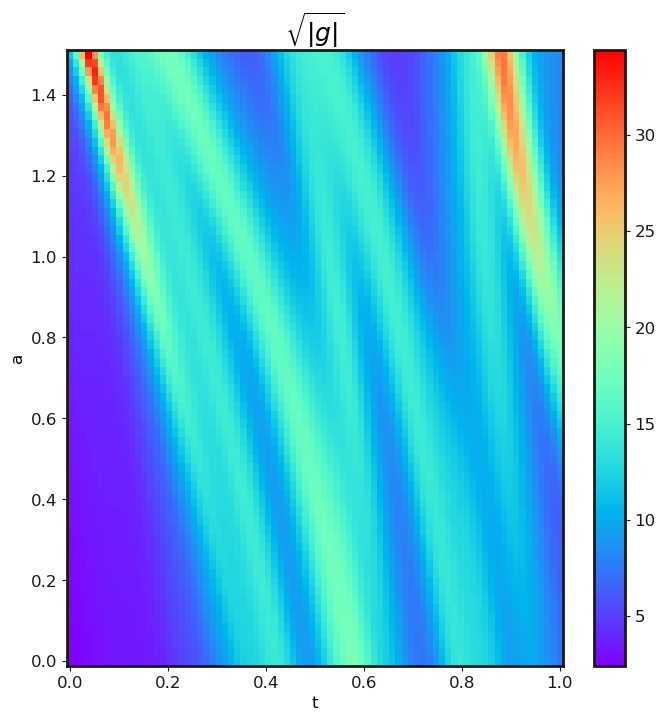

In [33]:
import matplotlib.colors as colors
pos = 0
plt.pcolormesh(T.detach().numpy()[pos:,::],A.detach().numpy()[pos:,::],g_det.detach().numpy()[pos:,::],cmap = 'rainbow')
plt.colorbar()
plt.title('$\sqrt{|g|}$')
plt.xlabel('t')
plt.ylabel('a')
plt.savefig('metric_y(t)_flat.pdf')
plt.show()

In [35]:
save_nets('15e5_flat_0_to_15',nets,adam,solver)


# TRANSFER LEARNING

In [54]:
# Initialize t_min, t_max, a_min and a_max
rho = 10

t_min = 0.0
t_max = 1

a_min = 0.0
a_max = 1.2

a_list = [1.75]

#a_list = np.linspace(a_min,a_max,9)
n_heads = 1

# Create the body and the nets #
H_NEW = [FCNN(n_input_units=2, hidden_units=[64,64,64,64], n_output_units = 128) for _ in range(2)]

heads_NEW = [[FCNN(n_input_units=128, hidden_units=[64,64], n_output_units = 1) for _ in range(n_heads)]
             for _ in range(len(H_NEW))]
nets = np.ones([len(H_NEW),n_heads],dtype=nn.Module) # i -> equation, j -> head #
for i in range(len(H_NEW)):
    #print(i)
    for j in range(n_heads):
        nets[i,j] = NET_FREEZE(H_NEW[i],heads_NEW[i][j])

# Create the equations #
eq_dict = {}
eq_dict = generate_equations(n_heads = n_heads)
#print(self.eq_dict)
equation_list = []
for head in range(n_heads):
    equations = eq_dict[f'equations_{head}']
    #print(equations)
    equation_list.append(equations)

print('Equation list ready')

print(nets.shape)

#gen = Generator1D(48,t_min,t_max,'equally-spaced-noisy')

adam = torch.optim.Adam(OrderedSet([ p for q in range(n_heads) for net in list(nets[:,q])
                                    for p in net.parameters()]), lr=3e-4)

scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=60000, gamma=0.97)
scheduler_cb = DoSchedulerStep(scheduler=scheduler)

# Define the initial conditions

init_val = [BundleIVP(t_min,1),
            BundleIVP(t_min,0)]

# Initialize the solver
solver = Solver1D_MH(a_list = a_list,
    all_nets = nets,
    t_sampling = 64,
    optimizer = adam,
    ode_system =  equation_list,
    conditions = init_val,
    t_min = t_min,
    t_max = t_max,
    flatten = False,
    n_batches_valid = 0
   #train_generator=gen,
)

# LOAD THE DATA #
load_nets('15e5_flat_0_to_15',nets = nets, optim = adam,solver = solver)

Equations dictionary generated
{'equations_0': <function generate_equations.<locals>.make_equations.<locals>.eq at 0x35a9b8180>}
Equation list ready
(2, 1)
head 0
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.eq at 0x35a9b8180>


/var/folders/jv/kc0s95qd0g955trdzv56sdc00000gn/T/ipykernel_25198/1861894753.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  master_dict = torch.load(path,map_location=t

Load head? False


In [65]:
#torch.autograd.set_detect_anomaly(True)
# Fit the solver
solver.fit(1000000,
               callbacks = [scheduler_cb])

Training Progress:   0%|                                                                                    | …

In [66]:
for g in adam.param_groups:
  #g['lr'] = 8e-6
  print(g['lr'])

8.762790517348117e-06


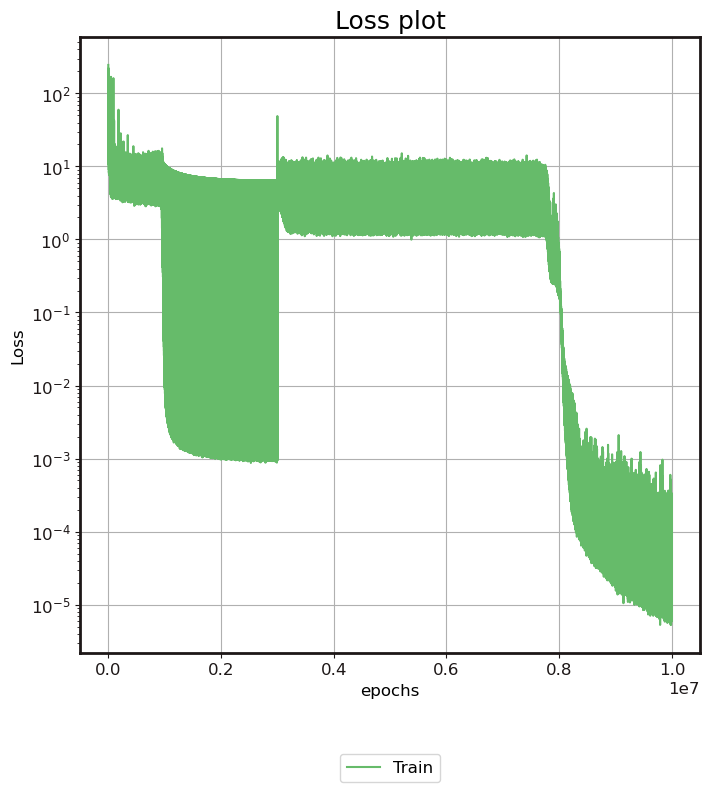

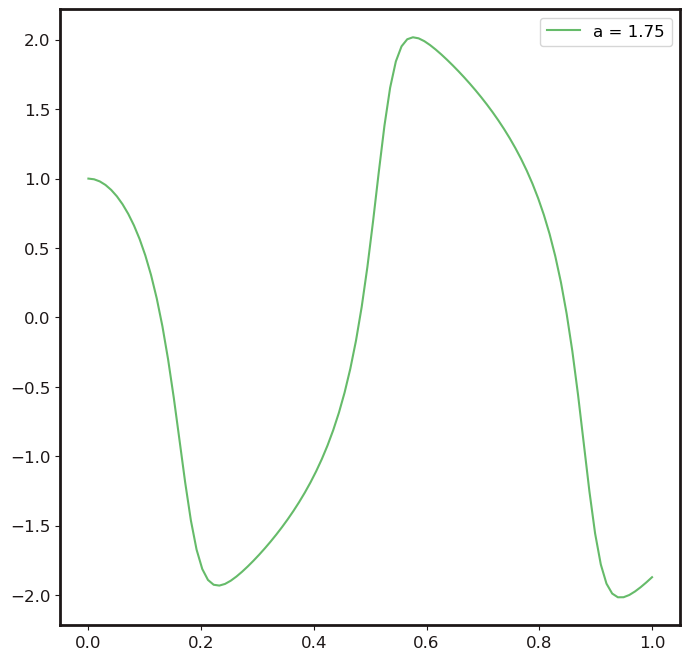

In [67]:

## Plot training history
t_vals = np.linspace(t_min, t_max, 100)
history = solver.metrics_history
plt.plot(history['train_loss'], label = 'Train')
#print(history['add_loss'])
#plt.plot(history['add_loss'], label = 'Add')


#
#if len(history['valid_loss']) != 0:
#    plt.plot(history['valid_loss'], label = 'Validation')

# Add axis labels, title and legend for clarity
plt.title('Loss plot')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
plt.savefig('loss_transfer_flat.pdf')
plt.show()

# Plot the variations of solutions for 5 values between a_min and a_max.
for head in range(solver.n_heads):
  solver.best_nets = nets[:,head]
  solution = solver.get_solution(best=True)
  a = a_list[head]*np.ones_like(t_vals)
  y1 = solution(t_vals,a)[0]
  plt.plot(t_vals,y1.cpu().detach().numpy(),label = 'a = ' + str(a_list[head]))
plt.legend()
plt.show()

# Get the numerica solution

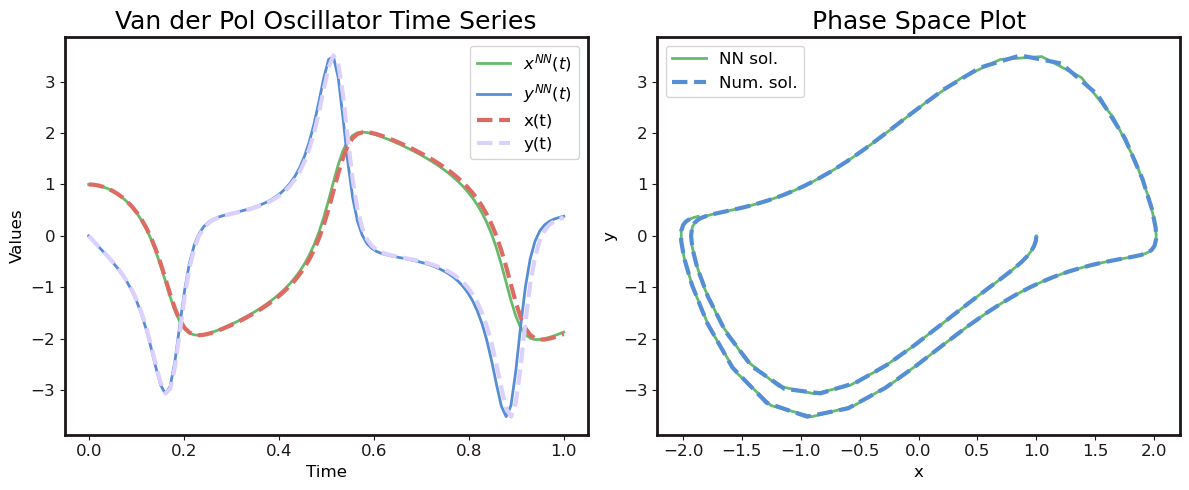

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Van der Pol oscillator equations


# Parameters
mu = a_list[0]  # Damping parameter
t0 = 0.0  # Initial time
t_end = 1  # End time
dt = 0.01  # Time step
n_steps = int((t_end - t0) / dt)  # Number of time steps

# Initial conditions
x0 = 1.0
y0 = 0.0
state = np.array([x0, y0])

# Time array
t = np.linspace(t0, t_end, n_steps)

# Arrays to store the solutions
x_sol = np.zeros(n_steps)
y_sol = np.zeros(n_steps)
x_sol[0] = x0
y_sol[0] = y0

# Time integration using RK4
for i in range(1, n_steps):
    state = rk4_step(van_der_pol, t[i-1], state, dt, mu)
    x_sol[i] = state[0]
    y_sol[i] = state[1]

# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for head in range(solver.n_heads):
  solver.best_nets = nets[:,head]
  solution = solver.get_solution(best=True)
  a = a_list[head]*np.ones_like(t_vals)
  y1 = solution(t_vals,a)[0]
  y2 = solution(t_vals,a)[1]
  plt.plot(t_vals,y1.cpu().detach().numpy(),label = '$x^{NN}(t)$',linewidth = 2)
  plt.plot(t_vals,y2.cpu().detach().numpy(),label = '$y^{NN}(t)$',linewidth = 2)
plt.plot(t, x_sol, label='x(t)',linestyle = 'dashed', linewidth = 3)
plt.plot(t, y_sol, label='y(t)',linestyle = 'dashed', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Van der Pol Oscillator Time Series')

plt.subplot(1, 2, 2)
plt.plot(y1.cpu().detach().numpy(),y2.cpu().detach().numpy(),label = 'NN sol.',linewidth = 2)
plt.plot(x_sol, y_sol,label = 'Num. sol.',linestyle = 'dashed', linewidth = 3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Space Plot')
plt.legend()

plt.tight_layout()
plt.savefig('transfer_solution_flat.pdf')
plt.show()


In [64]:
save_nets('Transfered_flat_1_7',nets,adam,solver)